In [2]:
import matplotlib.pyplot as plt

def imshow(img):
    img = img.cpu().numpy().transpose(1, 2, 0)
    plt.imshow(img)


## 1. 下载并预处理 MNIST

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

batch_size = 32

transform=transforms.Compose([
    transforms.ToTensor(),
    ])
# todo:一些预处理

train_data = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST('./data', train=False, transform=transform)

train_data, valid_data = torch.utils.data.random_split(train_data, [0.8, 0.2])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
print(len(train_data), len(valid_data), len(test_data))


48000 12000 10000


### 1.1 随机显示一下数据集的内容

type: <class 'torch.Tensor'>
size: torch.Size([32, 1, 28, 28])
    2     6     1     3     3     8     4     0
    0     2     0     7     3     5     2     6
    5     2     3     3     4     6     2     3
    1     6     6     6     6     3     1     9
type: <class 'torch.Tensor'>
size: torch.Size([32])


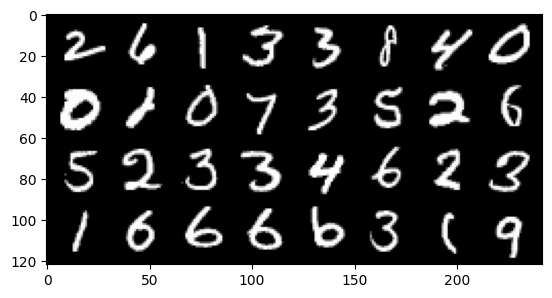

In [4]:
from random import randint
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

# get a batch of training images
images, labels = next(iter(train_loader))

# show labels
print(f'type: {type(images)}\nsize: {images.shape}')
print('\n'.join([' '.join('%5s' % classes[labels[j + 8 * i]] for j in range(8)) for i in range(batch_size>>3)]))
# show images
print(f'type: {type(labels)}\nsize: {labels.shape}')
imshow(torchvision.utils.make_grid(images))

## 2.定义并实例化模型

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 卷积层
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 全连接层
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)           # 卷积层
        x = F.relu(x)               # 激活函数
        x = F.avg_pool2d(x, 2)      # 池化层

        x = self.conv2(x)           # 卷积层
        x = F.relu(x)               # 激活函 
        x = F.avg_pool2d(x, 2)      # 池化层

        x = torch.flatten(x, 1)     # 降维

        x = self.fc1(x)             # 全连接层
        x = F.relu(x)               # 激活函数

        x = self.fc2(x)             # 全连接层
        x = F.relu(x)               # 激活函数

        x = self.fc3(x)             # 全连接层
        return x

net = Net()

### 2.1 使用一个输入进行尝试

tensor([[ 0.0793,  0.0856, -0.1059, -0.0387,  0.0341, -0.0813, -0.0779, -0.0079,
         -0.0162, -0.0674]], grad_fn=<AddmmBackward0>) torch.Size([1, 10])


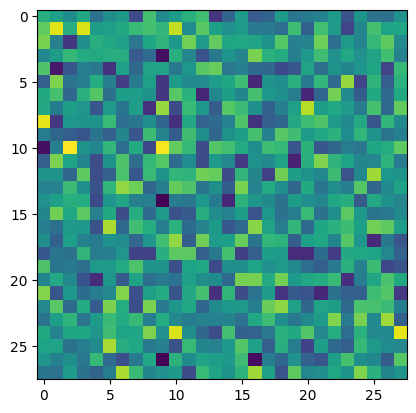

In [6]:
input = torch.randn(1, 1, 28, 28)
imshow(input[0])
out = net(input)
print(out, out.shape)

## 3.训练网络

### 3.1 设置损失函数与优化器

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.2)

### 3.2 训练网络

In [8]:
from tqdm import tqdm

def train():
    # 训练
    net.train()

    print(f"Epoch {epoch+1}:")
    running_loss = 0.0
    num_correct = 0

    for i, data in enumerate(tqdm(train_loader, desc = "\ttrain")):

        inputs, labels = data               # 训练数据
        optimizer.zero_grad()               # 清空梯度
        outputs = net(inputs)               # 计算输出
        loss = criterion(outputs, labels)   # 计算loss
        loss.backward()                     # 对loss反向传播
        optimizer.step()                    # 更新参数
        
        # 输出过程数据
        pred = outputs.argmax(dim=1)                                # 取出概率最大的类型作为预测结果
        num_correct += torch.eq(pred, labels).sum().int().item()    # 计算准确率
        running_loss += loss.item()

    # print statistics
    print(f'\t\ttrain loss:{(running_loss/len(train_loader))}')
    print(f'\t\ttrain acc:{num_correct/len(train_data)}')

def valid():
    net.eval()

    correct = 0
    total = 0
    class_correct = [0.] * 10
    class_total = [0.] * 10

    with torch.no_grad():
        for data in tqdm(valid_loader, desc="\tvalid"):
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f'\t\tvalid acc: {100 * correct / total}%')

for epoch in range(10):  # loop over the dataset multiple times
    train()    
    valid()

print('Finished Training')

Epoch 1:


	train: 100%|██████████| 1500/1500 [00:02<00:00, 531.41it/s]


		train loss:0.3228582278183506
		train acc:0.8924791666666667


	valid: 100%|██████████| 375/375 [00:00<00:00, 1087.40it/s]


		valid acc: 97.14166666666667%
Epoch 2:


	train: 100%|██████████| 1500/1500 [00:02<00:00, 649.86it/s]


		train loss:0.07173159349669003
		train acc:0.9777083333333333


	valid: 100%|██████████| 375/375 [00:00<00:00, 1090.76it/s]


		valid acc: 98.00833333333334%
Epoch 3:


	train: 100%|██████████| 1500/1500 [00:02<00:00, 650.81it/s]


		train loss:0.05066498091087366
		train acc:0.9844375


	valid: 100%|██████████| 375/375 [00:00<00:00, 410.16it/s]


		valid acc: 98.44166666666666%
Epoch 4:


	train: 100%|██████████| 1500/1500 [00:05<00:00, 290.47it/s]


		train loss:0.03880408748780367
		train acc:0.9879791666666666


	valid: 100%|██████████| 375/375 [00:00<00:00, 417.44it/s]


		valid acc: 98.44166666666666%
Epoch 5:


	train: 100%|██████████| 1500/1500 [00:05<00:00, 289.38it/s]


		train loss:0.032063072910811265
		train acc:0.9897708333333334


	valid: 100%|██████████| 375/375 [00:00<00:00, 687.34it/s]


		valid acc: 98.46666666666667%
Epoch 6:


	train: 100%|██████████| 1500/1500 [00:02<00:00, 560.71it/s]


		train loss:0.0268867655430513
		train acc:0.9911666666666666


	valid: 100%|██████████| 375/375 [00:00<00:00, 1088.38it/s]


		valid acc: 98.64166666666667%
Epoch 7:


	train: 100%|██████████| 1500/1500 [00:04<00:00, 302.28it/s]


		train loss:0.022120564161136523
		train acc:0.9927708333333334


	valid: 100%|██████████| 375/375 [00:00<00:00, 391.92it/s]


		valid acc: 98.85%
Epoch 8:


	train: 100%|██████████| 1500/1500 [00:05<00:00, 285.00it/s]


		train loss:0.018158382732071307
		train acc:0.9938541666666667


	valid: 100%|██████████| 375/375 [00:00<00:00, 391.49it/s]


		valid acc: 98.71666666666667%
Epoch 9:


	train: 100%|██████████| 1500/1500 [00:05<00:00, 288.17it/s]


		train loss:0.017663240154033397
		train acc:0.994125


	valid: 100%|██████████| 375/375 [00:00<00:00, 391.81it/s]


		valid acc: 98.75%
Epoch 10:


	train: 100%|██████████| 1500/1500 [00:05<00:00, 287.48it/s]


		train loss:0.012908520085244315
		train acc:0.9958125


	valid: 100%|██████████| 375/375 [00:00<00:00, 391.84it/s]

		valid acc: 98.75%
Finished Training


### 3.3 保存网络

In [9]:
torch.save(net.state_dict(), './mnist_lenet.pth')
# torch.save(net, './mnist_lenet_model') # 这两种save是不一样的，建议搞懂

## 4. 测试

### 4.1 加载模型

In [10]:
net = Net()
net.load_state_dict(torch.load('./mnist_lenet.pth'))

<All keys matched successfully>

### 4.2 在测试集上测试

In [11]:
correct = 0
total = 0
class_correct = [0.] * 10
class_total = [0.] * 10

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print(f'Accuracy on the test dataset: {100 * correct / total}%')
for i in range(10):
    print(f'Accuracy of {classes[i]} : {(100 * class_correct[i] / class_total[i])}%')

Accuracy on the test dataset: 98.93%
Accuracy of 0 : 99.06542056074767%
Accuracy of 1 : 99.27536231884058%
Accuracy of 2 : 99.24812030075188%
Accuracy of 3 : 98.4%
Accuracy of 4 : 99.1869918699187%
Accuracy of 5 : 100.0%
Accuracy of 6 : 98.24561403508773%
Accuracy of 7 : 100.0%
Accuracy of 8 : 99.2%
Accuracy of 9 : 100.0%


### 4.3 使用测试集数据来展示预测效果

GroundTruth:
    2     5     3     9     7     7     9     8
    7     6     6     1     2     6     3     6
    3     3     5     4     6     8     3     9
    9     1     0     1     0     5     7     3
Predicted: 
    2     5     3     9     7     7     9     8
    7     6     6     1     2     6     3     6
    3     3     5     4     6     8     3     9
    9     1     0     1     0     5     7     3


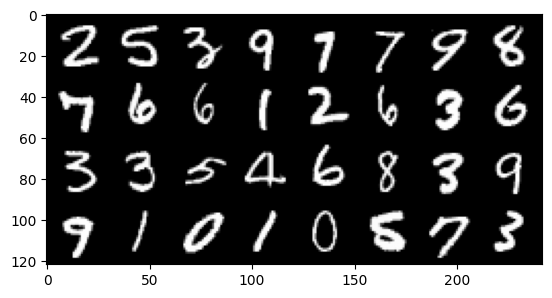

In [12]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

def red(s:str) -> str:
    return f'\033[91m{s}\033[0m'

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth:')
print('\n'.join([' '.join('%5s' % classes[labels[j + 8 * i]] for j in range(8)) for i in range(batch_size>>3)]))


outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ')
print('\n'.join([' '.join(
    ('%5s' % classes[predicted[j + 8 * i]]) if classes[predicted[j + 8 * i]] == classes[labels[j + 8 * i]] else red('%5s' % classes[predicted[j + 8 * i]])
    for j in range(8)) for i in range(batch_size>>3)]))